## Of 1year of Ride Requests Data at OLA Bikes

Time Window: 2020-03-26 to 2021-03-26

## Number of Good Ride Requests: 3708329

In [8]:
!pip install pandas_profiling
!pip install pydantic-settings


In [9]:
!pip install matplotlib
import pandas as pd
!pip install ydata-profiling


In [11]:
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
import gpxpy.geo
from datetime import datetime, timedelta
from joblib import dump, load
from ydata_profiling import ProfileReport  # Correct import for ydata-profiling

/Users/naveenakondraganti/Desktop/Demand_forecasting_ola_drivers /venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
df = pd.read_csv('./../Data/clean_data.csv', compression = 'gzip')

In [13]:
len(df)

3708329

# Geospacial Feature Engineering - Clustering/Segmentation
## Here, we have divided whole India into regions using “K-Means Clustering”.

In [14]:
coord = df[["pick_lat", "pick_lng"]].values
neighbors = []


In [15]:
def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = np.inf  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000, random_state = 5).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [16]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 0.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 9.0
Minimum distance between any two clusters = 2.0101294996567263
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 1.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 19.0
Minimum distance between any two clusters = 1.5107959540773708
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 1.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 19.0
Minimum distance between any two clusters = 1.5107959540773708
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inte

### I want the minimum inter cluster distance between any two clusters to be less than 0.5miles and when number of clusters are 50 then this condition is meeting. Therefore, we are considering number of clusters to be 50.

The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution. In contrast to other algorithms that reduce the convergence time of k-means, mini-batch k-means produces results that are generally only slightly worse than the standard algorithm.

In [17]:
coord = df[["pick_lat", "pick_lng"]].values
regions = MiniBatchKMeans(n_clusters = 50, batch_size = 10000, random_state = 0).fit(coord)
df["pickup_cluster"] = regions.predict(df[["pick_lat", "pick_lng"]])

/Users/naveenakondraganti/Desktop/Demand_forecasting_ola_drivers /venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(


In [18]:
df

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,geodesic_distance,hour,mins,day,month,year,dayofweek,booking_timestamp,booking_time_diff_hr,booking_time_diff_min,pickup_cluster
0,2020-10-10 07:34:16,-1,12.975773,77.571070,12.878468,77.445330,17.38,7,34,10,10,2020,5,1602315256,445087,26705254,16
1,2020-10-11 08:23:42,-1,12.930813,77.609530,12.960320,77.587210,4.06,8,23,11,10,2020,6,1602404622,24,1489,28
2,2020-10-11 11:57:17,-1,12.960213,77.587460,12.930824,77.609610,4.04,11,57,11,10,2020,6,1602417437,3,213,31
3,2020-10-16 17:51:07,-1,12.924353,77.549410,12.932216,77.581825,3.62,17,51,16,10,2020,4,1602870667,125,7553,23
4,2020-10-30 09:00:44,-1,12.945731,77.622500,12.973030,77.616840,3.08,9,0,30,10,2020,4,1604048444,327,19629,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708324,2021-02-12 19:37:11,99999,13.029848,77.593400,13.063751,77.589850,3.77,19,37,12,2,2021,4,1613158631,24,1498,24
3708325,2021-02-19 20:43:25,99999,13.029296,77.592580,12.927923,77.627106,11.82,20,43,19,2,2021,4,1613767405,169,10146,24
3708326,2021-02-20 17:34:45,99999,12.907576,77.600685,12.925874,77.607620,2.16,17,34,20,2,2021,5,1613842485,20,1251,32
3708327,2021-02-27 08:26:23,99999,12.956665,77.521870,12.948099,77.562990,4.56,8,26,27,2,2021,5,1614414383,158,9531,21


In [20]:
### Model to Define pickup cluster, given latitude and longitude
dump(regions, '../data/pickup_cluster_model.joblib', compress = 3)

['../data/pickup_cluster_model.joblib']

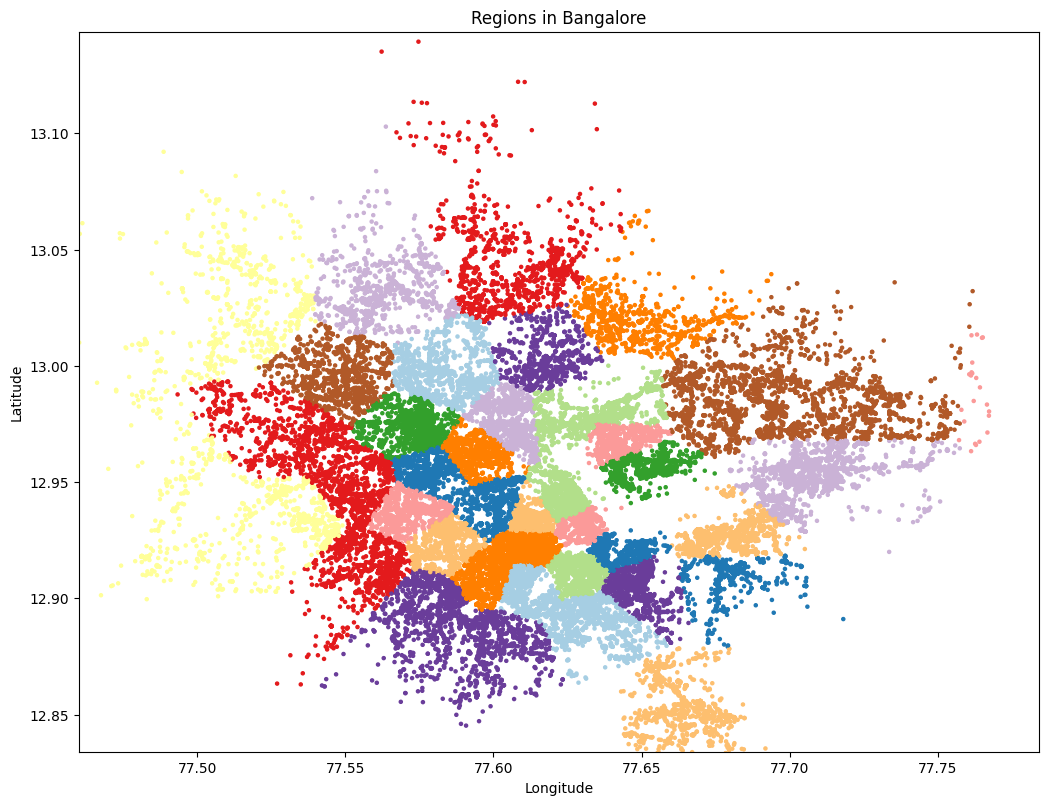

In [21]:
### These pickup clusters tell in which area most ride requests are coming. 
### Plotting Regions in Bangalore (our most rides requests here)
#### Bangalore:'boundingbox': ['12.8340125', '13.1436649', '77.4601025', '77.7840515']
bangalore_latitude_range = (12.8340125, 13.1436649)
bangalore_longitude_range = (77.4601025, 77.7840515)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = df.pick_lng.values[:100000], y = df.pick_lat.values[:100000], c = df.pickup_cluster.values[:100000], cmap = "Paired", s = 5)
ax.set_xlim(77.4601025, 77.7840515)
ax.set_ylim(12.8340125, 13.1436649)
ax.set_title("Regions in Bangalore")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#Longitude values vary from left to right i.e., horizontally
#Latitude values vary from top to bottom means i.e., vertically

In [22]:
df.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,geodesic_distance,hour,mins,day,month,year,dayofweek,booking_timestamp,booking_time_diff_hr,booking_time_diff_min,pickup_cluster
0,2020-10-10 07:34:16,-1,12.975773,77.57107,12.878468,77.445330,17.38,7,34,10,10,2020,5,1602315256,445087,26705254,16
1,2020-10-11 08:23:42,-1,12.930813,77.60953,12.960320,77.587210,4.06,8,23,11,10,2020,6,1602404622,24,1489,28
2,2020-10-11 11:57:17,-1,12.960213,77.58746,12.930824,77.609610,4.04,11,57,11,10,2020,6,1602417437,3,213,31
3,2020-10-16 17:51:07,-1,12.924353,77.54941,12.932216,77.581825,3.62,17,51,16,10,2020,4,1602870667,125,7553,23
4,2020-10-30 09:00:44,-1,12.945731,77.62250,12.973030,77.616840,3.08,9,0,30,10,2020,4,1604048444,327,19629,11


## Summing Ride Request Count to 30mins Interval groupby pickup cluster

In [23]:
def round_timestamp_30interval(x):
    if type(x)==str:
        x = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    return x- timedelta(minutes=x.minute%30, seconds=x.second, microseconds=x.microsecond)

df['ts'] = np.vectorize(round_timestamp_30interval)(df['ts'])


In [24]:

dataset = deepcopy(df)
dataset.ts = pd.to_datetime(dataset.ts)
dataset

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,geodesic_distance,hour,mins,day,month,year,dayofweek,booking_timestamp,booking_time_diff_hr,booking_time_diff_min,pickup_cluster
0,2020-10-10 07:30:00,-1,12.975773,77.571070,12.878468,77.445330,17.38,7,34,10,10,2020,5,1602315256,445087,26705254,16
1,2020-10-11 08:00:00,-1,12.930813,77.609530,12.960320,77.587210,4.06,8,23,11,10,2020,6,1602404622,24,1489,28
2,2020-10-11 11:30:00,-1,12.960213,77.587460,12.930824,77.609610,4.04,11,57,11,10,2020,6,1602417437,3,213,31
3,2020-10-16 17:30:00,-1,12.924353,77.549410,12.932216,77.581825,3.62,17,51,16,10,2020,4,1602870667,125,7553,23
4,2020-10-30 09:00:00,-1,12.945731,77.622500,12.973030,77.616840,3.08,9,0,30,10,2020,4,1604048444,327,19629,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708324,2021-02-12 19:30:00,99999,13.029848,77.593400,13.063751,77.589850,3.77,19,37,12,2,2021,4,1613158631,24,1498,24
3708325,2021-02-19 20:30:00,99999,13.029296,77.592580,12.927923,77.627106,11.82,20,43,19,2,2021,4,1613767405,169,10146,24
3708326,2021-02-20 17:30:00,99999,12.907576,77.600685,12.925874,77.607620,2.16,17,34,20,2,2021,5,1613842485,20,1251,32
3708327,2021-02-27 08:00:00,99999,12.956665,77.521870,12.948099,77.562990,4.56,8,26,27,2,2021,5,1614414383,158,9531,21


In [25]:
dataset = dataset[['ts','number','pickup_cluster']]

In [26]:
dataset=dataset.groupby(by = ['ts','pickup_cluster']).count().reset_index()
dataset.columns = ['ts','pickup_cluster','request_count']

In [27]:
dataset

,ts,pickup_cluster,request_count
0,2020-03-26 01:00:00,28,3
1,2020-03-26 01:00:00,34,1
2,2020-03-26 01:30:00,28,1
3,2020-03-26 01:30:00,47,2
4,2020-03-26 02:00:00,5,1
...,...,...,...
559035,2021-03-26 23:30:00,41,1
559036,2021-03-26 23:30:00,44,3
559037,2021-03-26 23:30:00,46,4
559038,2021-03-26 23:30:00,47,2


### There should be: 366days [2020-03-26 to 2021-03-26] * [(24*2) 30mins intervals] * 50 regions = 878400 data rows

In [ ]:
# ## Adding Dummy pickup cluster -1

# ## Change this Data based on your data
# l = [datetime(2020,3,26,00,00,00) + timedelta(minutes = 30*i) for i in range(0,48*365)]
# lt = []
# for x in l:
#     lt.append([x, -1, 0])
# temp = pd.DataFrame(lt, columns = ['ts','pickup_cluster','request_count'])
# dataset = dataset.append(temp,ignore_index=True)

In [30]:
## Adding Dummy pickup cluster -1

## Change this Data based on your data
l = [datetime(2020,3,26,00,00,00) + timedelta(minutes = 30*i) for i in range(0,48*365)]
lt = []
for x in l:
    lt.append([x, -1, 0])
temp = pd.DataFrame(lt, columns = ['ts','pickup_cluster','request_count'])
dataset = pd.concat([dataset, temp], ignore_index=True)

In [31]:
data = dataset.set_index(['ts', 'pickup_cluster']).unstack().fillna(value=0).asfreq(freq='30Min').stack().sort_index(level=1).reset_index()

/var/folders/_x/82_wr07s3kv_9gc4dv8p952h0000gn/T/ipykernel_96473/1117317111.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = dataset.set_index(['ts', 'pickup_cluster']).unstack().fillna(value=0).asfreq(freq='30Min').stack().sort_index(level=1).reset_index()


In [34]:
data.tail(5)

,ts,pickup_cluster,request_count
895963,2021-03-26 21:30:00,49,2.0
895964,2021-03-26 22:00:00,49,2.0
895965,2021-03-26 22:30:00,49,6.0
895966,2021-03-26 23:00:00,49,0.0
895967,2021-03-26 23:30:00,49,0.0


In [35]:
# Removing Dummy Cluster
data = data[data.pickup_cluster>=0]

In [36]:

assert len(data)==878400


## Adding TimeFeatures
### hour, mins, dayofweek, quarter & month (to capture seasonality winter ride count, summer ride count, rainy weather ride count)
### During Rainy weather or extreme winter or extreme summer months, ride request will vary with weather

In [37]:
data['mins'] = data.ts.dt.minute
data['hour'] = data.ts.dt.hour
data['day'] = data.ts.dt.day
data['month'] = data.ts.dt.month
data['dayofweek'] = data.ts.dt.dayofweek
data['quarter'] = data.ts.dt.quarter

/var/folders/_x/82_wr07s3kv_9gc4dv8p952h0000gn/T/ipykernel_96473/2769766533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mins'] = data.ts.dt.minute
/var/folders/_x/82_wr07s3kv_9gc4dv8p952h0000gn/T/ipykernel_96473/2769766533.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hour'] = data.ts.dt.hour
/var/folders/_x/82_wr07s3kv_9gc4dv8p952h0000gn/T/ipykernel_96473/2769766533.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [38]:
data

,ts,pickup_cluster,request_count,mins,hour,day,month,dayofweek,quarter
17568,2020-03-26 00:00:00,0,0.0,0,0,26,3,3,1
17569,2020-03-26 00:30:00,0,0.0,30,0,26,3,3,1
17570,2020-03-26 01:00:00,0,0.0,0,1,26,3,3,1
17571,2020-03-26 01:30:00,0,0.0,30,1,26,3,3,1
17572,2020-03-26 02:00:00,0,0.0,0,2,26,3,3,1
...,...,...,...,...,...,...,...,...,...
895963,2021-03-26 21:30:00,49,2.0,30,21,26,3,4,1
895964,2021-03-26 22:00:00,49,2.0,0,22,26,3,4,1
895965,2021-03-26 22:30:00,49,6.0,30,22,26,3,4,1
895966,2021-03-26 23:00:00,49,0.0,0,23,26,3,4,1


In [39]:
data.to_csv('./../Data/Data_Prepared.csv',index = False, compression = 'gzip')

In [42]:
profile = data.profile_report(title='Ride Request DataSet Analysis')
profile.to_file(output_file="data_analysis_ride_request.html")

/Users/naveenakondraganti/Desktop/Demand_forecasting_ola_drivers /venv/lib/python3.9/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)
Summarize dataset:  69%|██████▉   | 11/16 [00:00<00:01,  2.90it/s, Calculate auto correlation]/Users/naveenakondraganti/Desktop/Demand_forecasting_ola_drivers /venv/lib/python3.9/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 9 0 ... 9 0 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
/Users/naveenakondraganti/Desktop/Demand_fo

In [43]:
# profile